In [1]:
"""Sea Lion Prognostication Engine

https://www.kaggle.com/c/noaa-fisheries-steller-sea-lion-population-count
"""

import sys
import os
from collections import namedtuple
import operator
import glob
import csv 
from math import sqrt

import numpy as np

import PIL
from PIL import Image, ImageDraw, ImageFilter

from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
import pickle

In [3]:
%cd ~/nbs/ssd_keras/
import pickle
from ssd import SSD300
from ssd_training import MultiboxLoss
from ssd_utils import BBoxUtility

/home/ubuntu/nbs/ssd_keras


In [69]:
from keras.applications.imagenet_utils import preprocess_input,decode_predictions

from keras.models import Sequential
from keras.layers import Dense
from keras.models import Model
from keras_tqdm import TQDMNotebookCallback

## preprocess

In [5]:
#ssd setup
NUM_CLASSES=2

%cd ~/nbs/ssd_keras/
priors = pickle.load(open('prior_boxes_ssd300.pkl', 'rb'))
bbox_util = BBoxUtility(NUM_CLASSES, priors)

/home/ubuntu/nbs/ssd_keras


In [6]:
% cd /mnt/kaggle_seals/

/mnt/kaggle_seals


In [7]:
import pickle
from collections import namedtuple
SeaLionCoord = namedtuple('SeaLionCoord', ['tid', 'cls', 'x', 'y'])
cord_list = pickle.load(open('cord_list.pkl', 'rb'))

In [11]:
# Count sea lion dots and compare to truth from train.csv
'''
sld = SeaLionData()
sld.verbosity = VERBOSITY.VERBOSE
cord_list=[]
for tid in sld.train_ids:
    coord = sld.coords(tid)
    cord_list.append(coord)
    pickle.dump( cord_list, open( "cord_list.pkl", "wb" ) )
'''

'\nsld = SeaLionData()\nsld.verbosity = VERBOSITY.VERBOSE\ncord_list=[]\nfor tid in sld.train_ids:\n    coord = sld.coords(tid)\n    cord_list.append(coord)\n    pickle.dump( cord_list, open( "cord_list.pkl", "wb" ) )\n'

In [12]:
bad_train_ids = (
            3, 7, 9, 21, 30, 34, 71, 81, 89, 97, 151, 184, 215, 234, 242, 
            268, 290, 311, 331, 344, 380, 384, 406, 421, 469, 475, 490, 499, 
            507, 530, 531, 605, 607, 614, 621, 638, 644, 687, 712, 721, 767, 
            779, 781, 794, 800, 811, 839, 840, 869, 882, 901, 903, 905, 909, 
            913, 927, 946)

In [13]:
train_nb = 947
tids = range(0, train_nb)
tids = list(set(tids) - set(bad_train_ids) )  # Remove bad ids
tids.sort()

In [62]:
'''
pickle.dump( cord_list, open( "cord_list.pkl", "wb" ) )

In [14]:
cord_list = pickle.load(open('cord_list.pkl', 'rb'))

the cord_list contains a sub list for every training image, with type of seal. it's pretty accurate

In [15]:
def read_image(i):
    img=np.array(Image.open('Train/{}.jpg'.format(i)))
    img_dot=np.array(Image.open('TrainDotted/{}.jpg'.format(i)))
    return img,img_dot

In [16]:
import pickle
from collections import namedtuple
SeaLionCoord = namedtuple('SeaLionCoord', ['tid', 'cls', 'x', 'y'])
cord_list = pickle.load(open('cord_list.pkl', 'rb'))

## prepare crops

In [ ]:
#generator - not ready yet
class Generator:
    def __init__(self, gt, bbox_util, #gt - raw anotation list
                 batch_size, path_prefix,
                 train_keys, val_keys, image_size):
        self.gt = gt
        self.bbox_util = bbox_util
        self.batch_size = batch_size
        self.path_prefix = path_prefix
        self.train_keys = train_keys
        self.val_keys = val_keys
        self.train_batches = len(train_keys)
        self.val_batches = len(val_keys)
        self.image_size = image_size
        
    def generate(self, train=True):
        while True:
            if train:
                shuffle(self.train_keys)
                keys = self.train_keys
            else:
                shuffle(self.val_keys)
                keys = self.val_keys
            inputs = []
            targets = []
            for key in keys:            
                img_path = self.path_prefix + key
                img = imread(img_path).astype('float32')
                
                y = self.gt[key].copy()
                if train and self.do_crop:
                    img, y = self.random_sized_crop(img, y)
                img = imresize(img, self.image_size).astype('float32')
                
                y = self.bbox_util.assign_boxes(y)
                inputs.append(img)                
                targets.append(y)
                if len(targets) == self.batch_size:
                    tmp_inp = np.array(inputs)
                    tmp_targets = np.array(targets)
                    inputs = []
                    targets = []
                    #plt.imshow(preprocess_input(tmp_inp)[0].astype('uint8'))
                    yield preprocess_input(tmp_inp), tmp_targets
                    # the preprocess is to bring the image to image net style...

In [ ]:
#instantiate generator
gen = Generator(new_gt, bbox_util, 16, '',
                train_keys, val_keys,
                (300,300))

In [ ]:
#train with generator. for this to wark, need to save all images
history = model.fit_generator(gen.generate(True), gen.train_batches,
                              nb_epoch, verbose=1,callbacks=callbacks,
                              validation_data=gen.generate(False),
                              nb_val_samples=gen.val_batches,
                              nb_worker=1)

In [121]:
#crop for ssd
m=0
anot_id_list=[]
anot_content_list=[]
train_inputs=[]
train_targets=[]
raw_anot_list=[] #e.g 2500,2580,1400,1480
crop_size=300
bb_size=80

#fig = plt.figure(figsize=(16,12))
#n_images_per_row=4
#choices=np.random.choice(100,16)
#choices=range(16)
for tid in tids: #file id
    img,_=read_image(tid)
    cords=cord_list[int(tid)]
    m+=1
    for seal_id,cord in enumerate(cords):
        shift_x=np.random.choice(crop_size-60)-120
        shift_y=np.random.choice(crop_size-60)-120
        xmin_crop=cord_list[tid][seal_id][2]-crop_size/2+shift_x
        ymin_crop=cord_list[tid][seal_id][3]-crop_size/2+shift_y
        xmax_crop=cord_list[tid][seal_id][2]+crop_size/2+shift_x
        ymax_crop=cord_list[tid][seal_id][3]+crop_size/2+shift_y
        
        cropped=img[ymin_crop:ymax_crop,xmin_crop:xmax_crop]

        xmin_bb=crop_size/2-bb_size/2-shift_x
        ymin_bb=crop_size/2-bb_size/2-shift_y
        xmax_bb=xmin_bb+bb_size
        ymax_bb=ymin_bb+bb_size

        if cropped.shape[0]==crop_size and cropped.shape[1]==crop_size:
            
            raw_anot=[[xmin_bb,ymin_bb,xmax_bb,ymax_bb]]
            anot_data=[[xmin_bb/crop_size,ymin_bb/crop_size,xmax_bb/crop_size,ymax_bb/crop_size,1]]
            anot_id_list.append(tid)
            anot_content_list.append(anot_data)

            z = anot_data.copy()

            z_processed = bbox_util.assign_boxes(np.array(z))
            #train_inputs.append(cropped.astype('float32'))  #.astype('float32')           
            #train_targets.append(z_processed)
            raw_anot_list.append(raw_anot)   
            pickle.dump( cropped, open( "/mnt/kaggle_seals/extracted_seals/file_"+str(tid)\
                                       +"_img_"+str(seal_id)+".pkl", "wb" ) )
    #if m>100:
    #    break #dont do all at once.. no choice. need to use generator, for easing on memory
    print(m)       
#train_target_array=np.array(train_targets)

#train_array=np.array(train_inputs)
#X=preprocess_input(train_array)

/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:27: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


IndexError: list index out of range

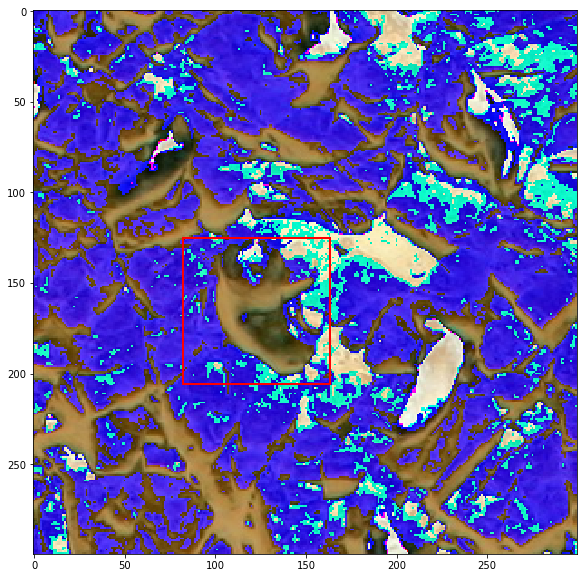

In [41]:
#sanity test
i=1#img_id

fig = plt.figure(figsize=(10,10))
plt.imshow(train_array[i])
currentAxis = plt.gca()

#color = colors[label]
xmin, ymin, xmax, ymax=anot_content_list[i][0][:4] #seal id in img
xmin, ymin, xmax, ymax=(xmin*crop_size, ymin*crop_size, xmax*crop_size, ymax*crop_size)
currentAxis.add_patch(plt.Rectangle((xmin, ymin), xmax-xmin+1, ymax-ymin+1, fill=False, edgecolor='r', linewidth=2))

/home/ubuntu/anaconda3/envs/py27/lib/python2.7/site-packages/matplotlib/axes/_base.py:3179: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=-0.5, top=-0.5
  'bottom=%s, top=%s') % (bottom, top))


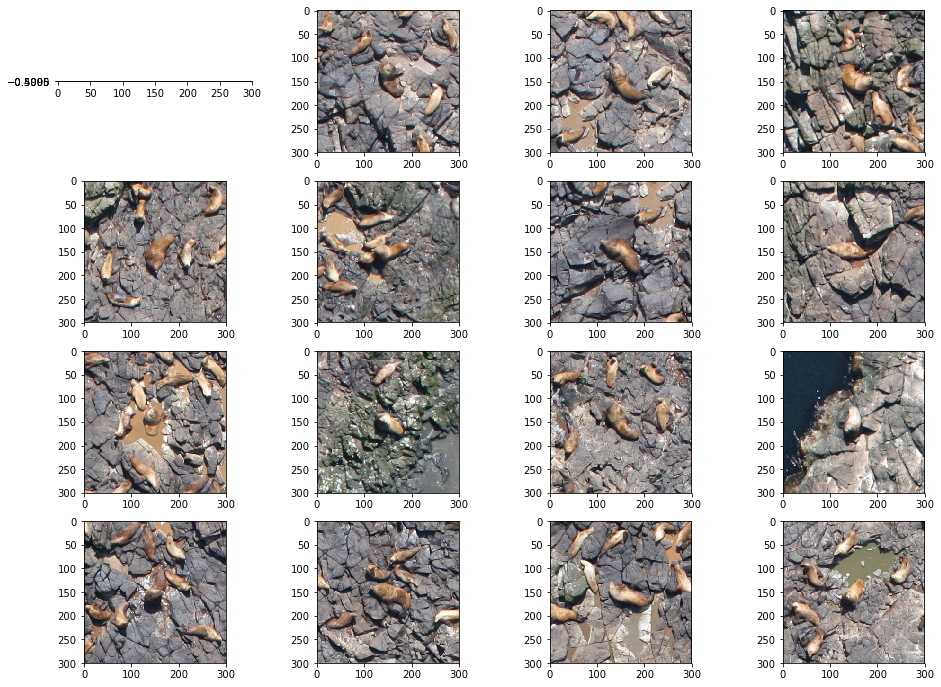

In [76]:
#show and tell
image_id=0
size=150
fig = plt.figure(figsize=(16,12))
n_images_per_row=4
choices=np.random.choice(100,16)
#choices=range(16)
for i,seal_id in enumerate(choices):
    a=img_dot[cord_list[image_id][seal_id][3]-size:cord_list[image_id][seal_id][3]+size,\
                       cord_list[image_id][seal_id][2]-size:cord_list[image_id][seal_id][2]+size]
    ax = fig.add_subplot(4,n_images_per_row,i+1)
    plt.grid(False)
    #plt.imshow(lion_patches[j])
    plt.imshow(a)
    

## train SSD

as of 17.4, I couldnt get decent traing results with ssd

In [2]:
#callback s

hist_folder='/mnt/kaggle_seals/ssd_checkpoints/weights.{epoch:02d}-{val_loss:.2f}.hdf5'

def schedule(epoch, decay=0.9):
    return base_lr * decay**(epoch)

callbacks = [keras.callbacks.ModelCheckpoint(hist_folder,
        verbose=1, save_weights_only=True),keras.callbacks.LearningRateScheduler(schedule),
            TQDMNotebookCallback(leave_inner=True)]

NameError: name 'TQDMNotebookCallback' is not defined

In [48]:
#split
from sklearn.model_selection import train_test_split

X_trn,X_val,y_trn,y_val=train_test_split(X,train_target_array)

In [49]:
input_shape = (300, 300, 3)
model = SSD300(input_shape, num_classes=NUM_CLASSES)

model.load_weights('/mnt/weights_SSD300.hdf5', by_name=True)

In [50]:
freeze = ['input_1', 'conv1_1', 'conv1_2', 'pool1', 'conv2_1', 'conv2_2', 'pool2', 'conv3_1', 'conv3_2', 'conv3_3', 'pool3']#,
#           'conv4_1', 'conv4_2', 'conv4_3', 'pool4']

for L in model.layers:
    if L.name in freeze:
        L.trainable = False

In [51]:
base_lr = 3e-4
optim = keras.optimizers.Adam(lr=base_lr)
# optim = keras.optimizers.RMSprop(lr=base_lr)
# optim = keras.optimizers.SGD(lr=base_lr, momentum=0.9, decay=decay, nesterov=True)
model.compile(optimizer=optim,loss=MultiboxLoss(NUM_CLASSES, neg_pos_ratio=2.0).compute_loss)

In [65]:
#train SSD
history=model.fit(X_trn,y_trn,batch_size=16,nb_epoch=30,
          callbacks=callbacks,
          validation_data=(X_val,y_val),
          verbose=0)
#best:Epoch 5:
#[loss: 2.021, val_loss: 2.052] 100% 473/473 [12:29<00:00, 33.26s/it]



Epoch 00000: saving model to /mnt/kaggle_seals/ssd_checkpoints/weights.00-2.09.hdf5
Epoch 00001: saving model to /mnt/kaggle_seals/ssd_checkpoints/weights.01-2.08.hdf5
Epoch 00002: saving model to /mnt/kaggle_seals/ssd_checkpoints/weights.02-2.06.hdf5
Epoch 00003: saving model to /mnt/kaggle_seals/ssd_checkpoints/weights.03-2.06.hdf5
Epoch 00004: saving model to /mnt/kaggle_seals/ssd_checkpoints/weights.04-2.05.hdf5
Epoch 00005: saving model to /mnt/kaggle_seals/ssd_checkpoints/weights.05-2.05.hdf5
Epoch 00006: saving model to /mnt/kaggle_seals/ssd_checkpoints/weights.06-2.07.hdf5
Epoch 00007: saving model to /mnt/kaggle_seals/ssd_checkpoints/weights.07-2.06.hdf5
Epoch 00008: saving model to /mnt/kaggle_seals/ssd_checkpoints/weights.08-2.08.hdf5
Epoch 00009: saving model to /mnt/kaggle_seals/ssd_checkpoints/weights.09-2.11.hdf5
Epoch 00010: saving model to /mnt/kaggle_seals/ssd_checkpoints/weights.10-2.13.hdf5
Epoch 00011: saving model to /mnt/kaggle_seals/ssd_checkpoints/weights.11-

KeyboardInterrupt: 

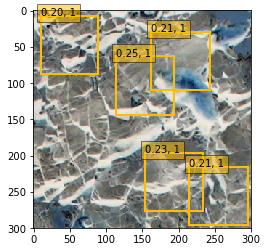

In [111]:
colors = plt.cm.hsv(np.linspace(0, 1, 9)).tolist()
ids=np.random.choice(2640,25)

j=6
#for i in range(25):
    #fig = plt.figure(figsize=(20,20))
    #ax = fig.add_subplot(1,2,1)
    #plt.imshow(cropped_dotted)
    #ax = fig.add_subplot(5,5,i+1)
    #plt.grid(False)
plt.imshow(X[j])

val_preds=model.predict(np.expand_dims(X[j],0)) #ssd predict
results = bbox_util.detection_out(val_preds)
currentAxis = plt.gca()

for i in range(5):
    relevant_results=results[0]
    xmin = int(round(relevant_results[i][2] * 300))
    ymin = int(round(relevant_results[i][3] * 300))
    xmax = int(round(relevant_results[i][4] * 300))
    ymax = int(round(relevant_results[i][5] * 300))
    label = int(relevant_results[i][0])
    score = relevant_results[i][1]
    coords = [(xmin, ymin), xmax-xmin+1, ymax-ymin+1]
    color = colors[label]
    currentAxis.add_patch(plt.Rectangle(*coords, fill=False, edgecolor=color, linewidth=2))
    display_txt = '{:0.2f}, {}'.format(score, label)
    currentAxis.text(xmin, ymin, display_txt, bbox={'facecolor':color, 'alpha':0.5})

In [108]:
#"un-preprocessing"
X[j]=X[j][ :, :, ::-1]
X[j][:, :, 0] += 103.939
X[j][:, :, 1] += 116.779
X[j][:, :, 2] += 123.68

### validation

## train VGG

## predict/Submit